In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import FigureCanvasPdf, PdfPages
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
plt.rcParams['image.cmap'] = 'inferno'
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)


import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from neurodsp import sim, plts
import numpy as np
from numpy import log10
from scipy import random, signal, stats
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA

In [2]:
from scipy.stats import expon
def lorentzian(f, A, k, exp):
    return A/(k+f**exp)

def exp_prob(xs, lambdas):
    return lambdas*np.exp(-xs*lambdas)
#     return expon.pdf(xs,scale=1/lambdas)

In [303]:
# Define the components of the combined signal to simulate
components = {'sim_synaptic_current' : {'n_neurons' : 1000, 'firing_rate' : 2, 't_ker' : 1.0,
                                         'tau_d' : 0.02},
              'sim_oscillation' : {'freq' : 8.2}}

sig = sim.sim_combined(n_seconds=180, fs=1000, components=components, component_variances=[1,0.4])
nperseg=1000
#f_stft, t_stft, stft = signal.stft(sig, fs=1000, window=np.ones(nperseg), nperseg=nperseg, noverlap=0, boundary=None, return_onesided=True)

# compute STFT
f_stft, t_stft, stft = signal.stft(sig, fs=1000, nperseg=nperseg, noverlap=0, boundary=None)

# # compute power and phase
# power, phase = compute_power_phase(stft)
power = abs(stft)**2

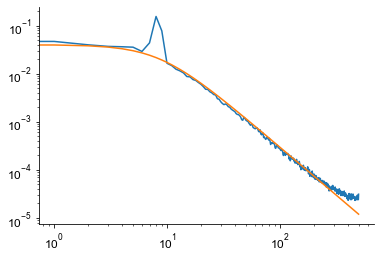

In [304]:
A, k, exp = 3, 75, 2
plt.loglog(np.mean(power,1))
plt.loglog(f_stft, lorentzian(f_stft, A, k, exp))

In [398]:
def spectral_logL(params, data_f, data_p):
    A, k, exp = params
    logL = []
    for i_f, f in enumerate(data_f):
        lmb = 1/lorentzian(f, A, k, exp)
    #     lmb = 1/p.mean()
        logL.append(np.log10(exp_prob(data_p[i_f],lmb)))
    
    return np.array(logL)

def total_neglogL(params, data_f, data_p):
    return -np.array(spectral_logL(params, data_f, data_p)).sum()

#     plt.plot(f_stft,np.array(logL).mean(1))


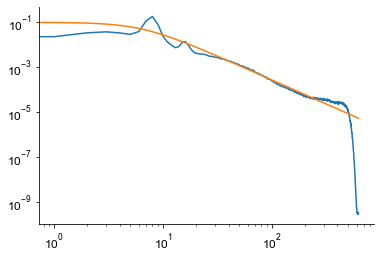

In [399]:
res = minimize(total_neglogL, (2, 50, 2), (f_stft[2:100], power[2:100]))
res.x
A, k, exp = res.x
plt.loglog(np.mean(power,1))
plt.loglog(f_stft, lorentzian(f_stft, A, k, exp))

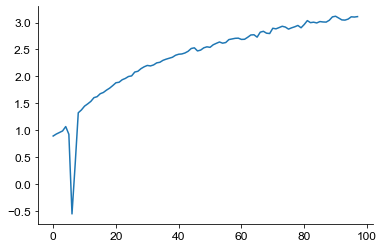

In [307]:
# plt.imshow(np.log10(power[:100]))
slogL = spectral_logL(res.x, f_stft[2:100], power[2:100])
# plt.imshow(slogL)
plt.plot(slogL.mean(1))

In [24]:
def make_df(f_stft, power):
    return pd.DataFrame(np.array([f_stft.repeat(power.shape[1]),power.flatten(), np.nan*np.ones(np.size(power))]).T, 
                        columns=['freq', 'power', 'lh'])

def compute_logL_flattened(params, data_f, data_p):
    A, k, exp = params
    lmb = 1/lorentzian(data_f, A, k, exp)
    return np.log10(exp_prob(data_p,lmb))

def total_neglogL(params, data_f, data_p):
    return -compute_logL_flattened(params, data_f, data_p).sum()
#     return -np.array(spectral_logL(params, data_f, data_p)).sum()

# real data

In [27]:
from scipy import io
data = io.loadmat('/Users/rdgao/Documents/data/CRCNS/hc2/Raw/lfp_spiketimes_ec013.527.mat', squeeze_me=True)
fs = data['srate']
lfp = data['data'][20]
lfp = (lfp-lfp.mean())/np.std(lfp)
# compute STFT
f_stft, t_stft, stft = signal.stft(lfp[int(fs*30):-int(fs*30)], fs=fs, nperseg=int(fs), noverlap=0, boundary=None)
power = abs(stft)**2

In [28]:
# bounds = [[0.01,10],[10,1000],[0,4]]
# x0 = (1, 20, 2)
# res = minimize(total_neglogL, x0, (f_stft[:100], power[:100]), bounds=bounds)
# print(res)
# res_psd = minimize(total_neglogL, x0, (f_stft[:100], power.mean(1)[:100]), bounds=bounds)
# print(res_psd)

# plt.figure(figsize=(4,4))
# plt.loglog(f_stft[:100], np.mean(power,1)[:100], label='data')
# A, k, exp = res.x
# plt.loglog(f_stft[:100], lorentzian(f_stft, A, k, exp)[:100], label='full_fit')
# A, k, exp = res_psd.x
# plt.loglog(f_stft[:100], lorentzian(f_stft, A, k, exp)[:100], label='psd_fit')
# plt.legend()

In [29]:
# slogL = spectral_logL(res.x, f_stft[2:100], power.mean(1)[2:100])
# # plt.imshow(slogL)
# # plt.plot(-slogL)
# # plt.xscale('log')

# slogL = spectral_logL(res.x, f_stft[2:100], power[2:100])
# # plt.imshow(slogL)
# plt.plot(np.mean(slogL,1))

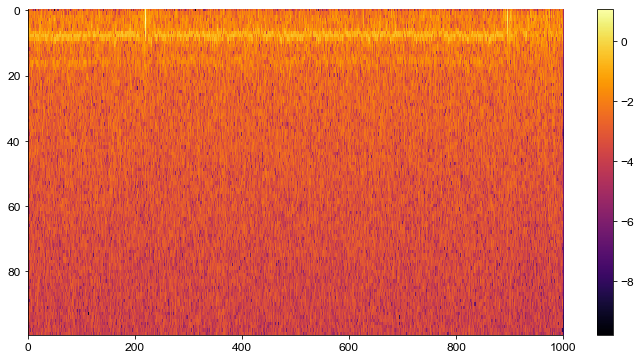

In [30]:
plt.figure(figsize=(12,6))
# plt.imshow(-np.argsort(slogL, axis=0), aspect='auto')

# nll_rank = np.argsort(slogL, axis=None).reshape(slogL.shape)
# plt.imshow(nll_rank*(nll_rank>20000), aspect='auto')
plt.imshow(np.log10(power[:100,:]), aspect='auto')
plt.colorbar()

# iterative fit

In [38]:
npct = 0.5
df_spg = make_df(f_stft[:100], power[:100,:])
psd = df_spg.groupby('freq').mean()['power']
psd_med = df_spg.groupby('freq').median()['power']

# subselect on freq bounds
df_select = df_spg[(df_spg['freq']>=1) & (df_spg['freq']<=100)]

bounds = [[0.01,10],[1,100000],[0,5]]
x0 = (1, 20, 2)

# res = minimize(total_neglogL, x0, (df_select['freq'].values, df_select['power'].values), bounds=bounds)
# res.x
# plt.figure(figsize=(4,4))
# plt.loglog(psd.index, psd, label='data mean')
# plt.loglog(psd.index, psd_med, label='data median')
# A, k, exp = res.x
# plt.loglog(psd.index, lorentzian(psd.index, *res.x), label='full_fit')

99.00 percent data:
offset: 5.630, knee: 75.557, exponent: 2.176
mean trimmed logL: nan
---
98.50 percent data:
offset: 4.696, knee: 105.524, exponent: 2.129
mean trimmed logL: 2.352
---
98.01 percent data:
offset: 4.072, knee: 122.057, exponent: 2.092
mean trimmed logL: 2.376
---
97.52 percent data:
offset: 3.844, knee: 145.153, exponent: 2.076
mean trimmed logL: 2.395
---
97.03 percent data:
offset: 3.780, knee: 171.748, exponent: 2.071
mean trimmed logL: 2.411
---
96.55 percent data:
offset: 3.807, knee: 201.162, exponent: 2.071
mean trimmed logL: 2.424
---
96.06 percent data:
offset: 3.810, knee: 226.824, exponent: 2.071
mean trimmed logL: 2.436
---
95.58 percent data:
offset: 3.820, knee: 250.618, exponent: 2.072
mean trimmed logL: 2.448
---
95.10 percent data:
offset: 3.947, knee: 285.754, exponent: 2.080
mean trimmed logL: 2.458
---
94.63 percent data:
offset: 4.056, knee: 320.234, exponent: 2.086
mean trimmed logL: 2.468
---
94.15 percent data:
offset: 4.281, knee: 370.534, exp

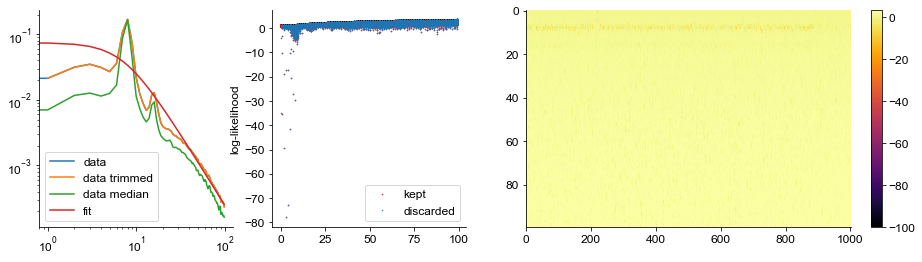

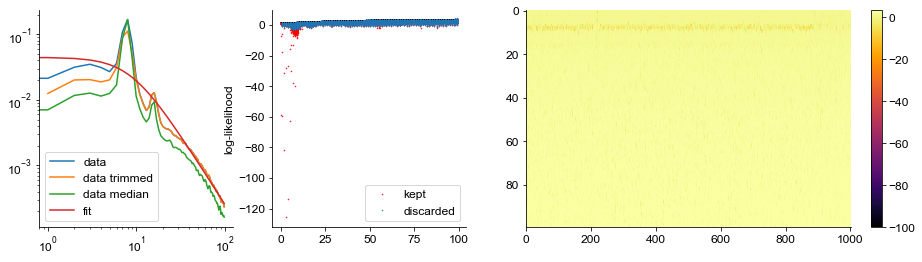

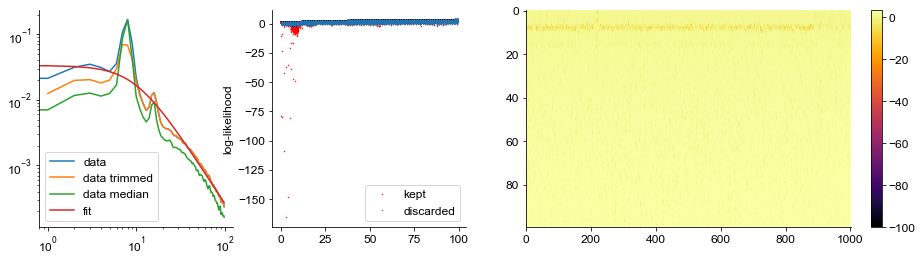

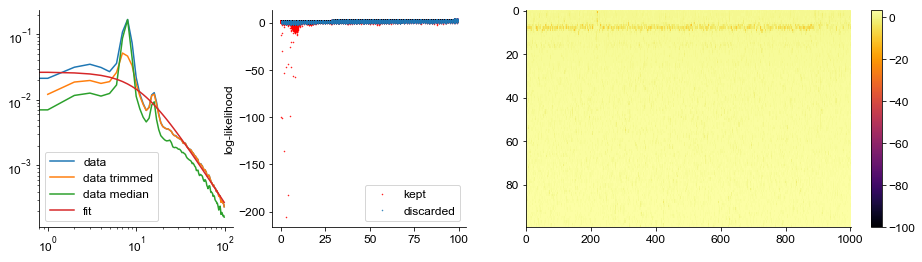

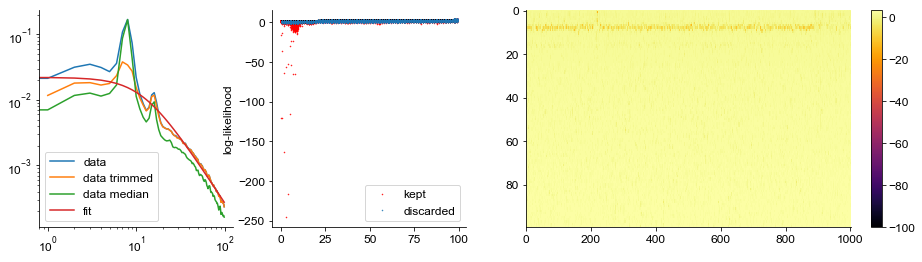

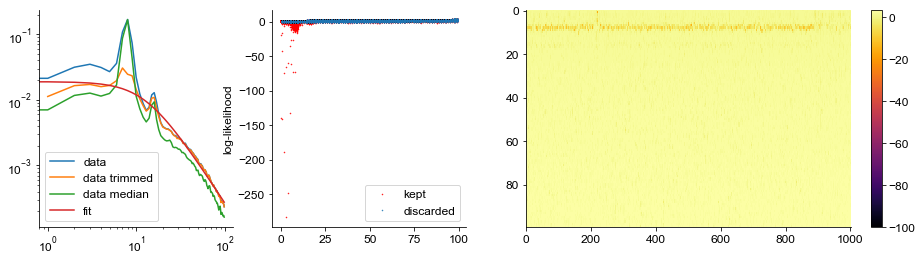

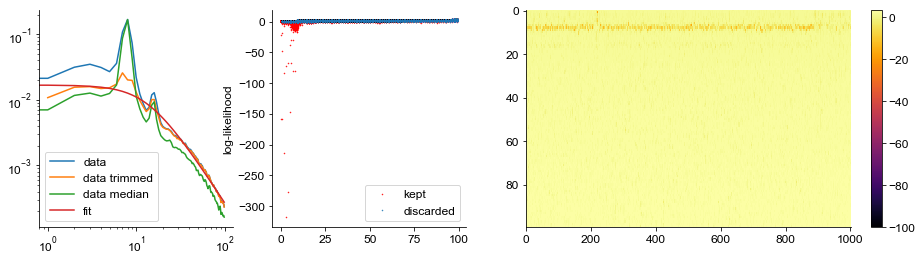

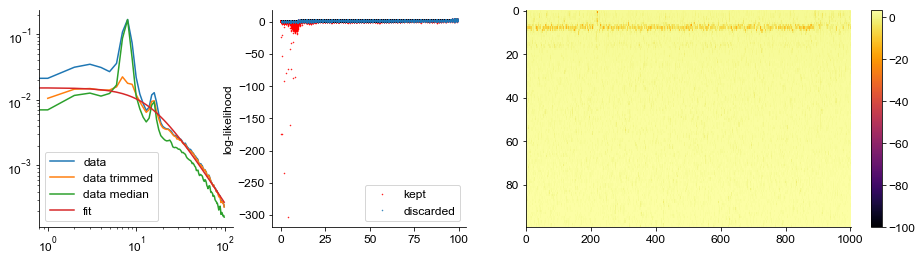

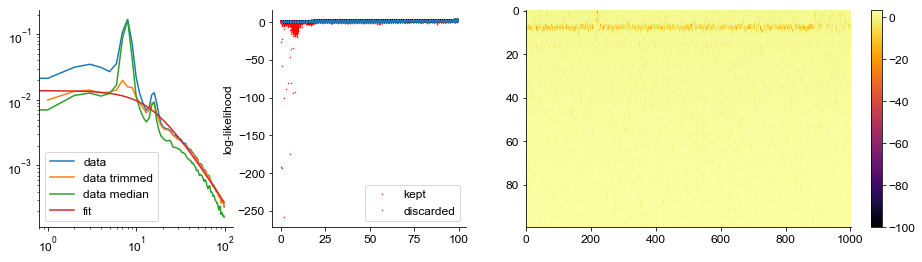

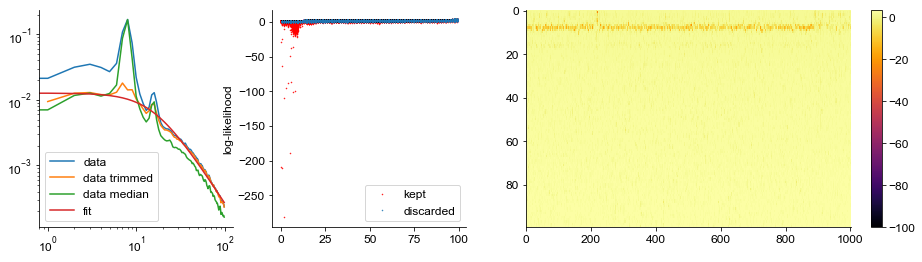

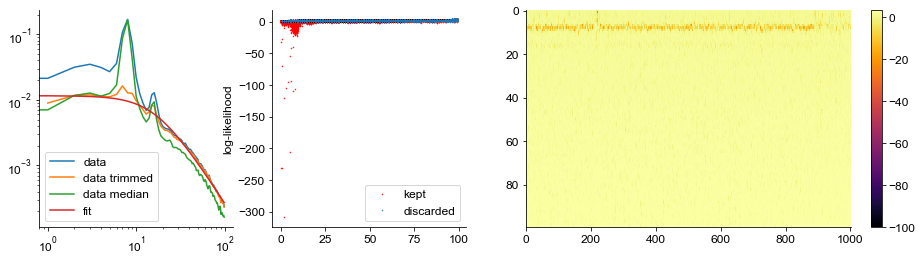

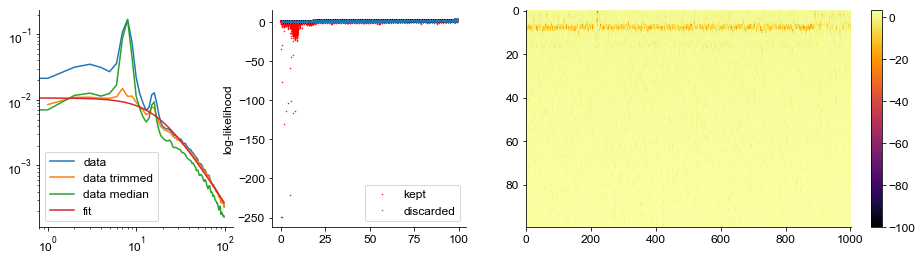

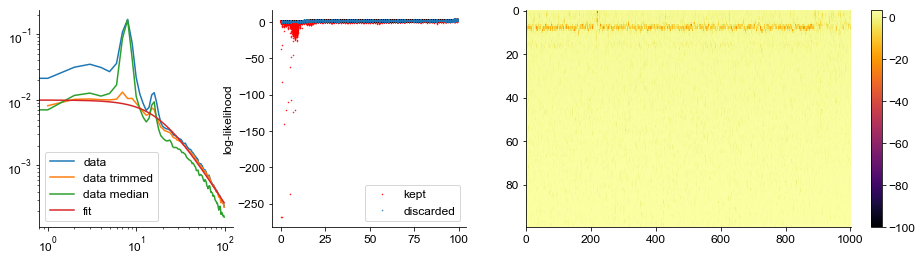

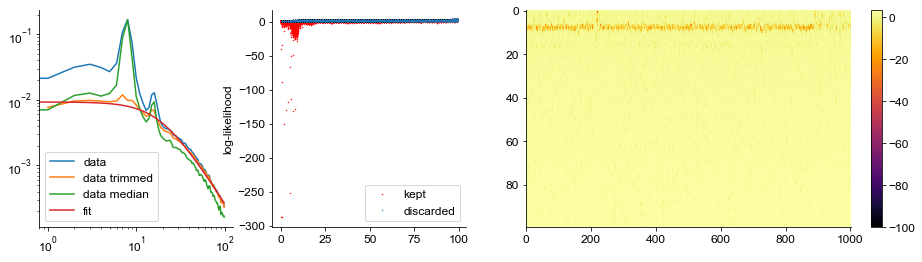

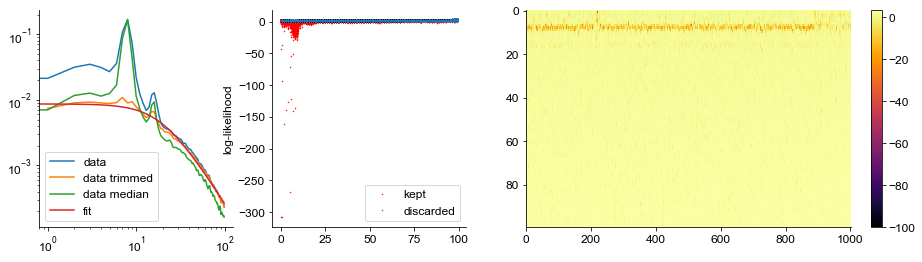

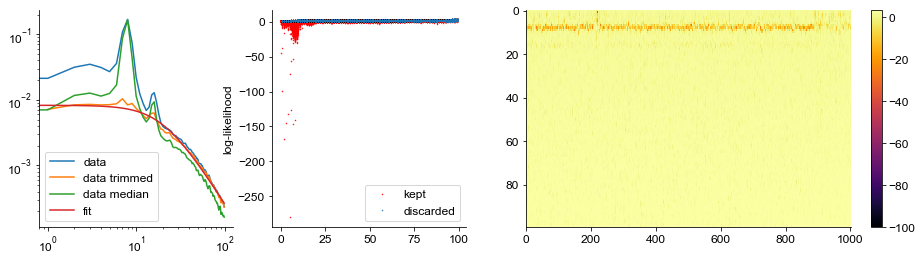

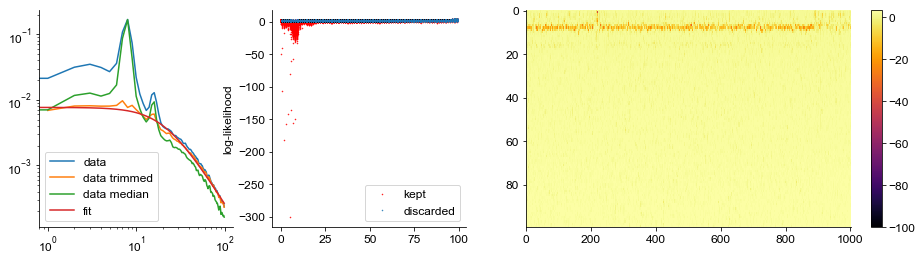

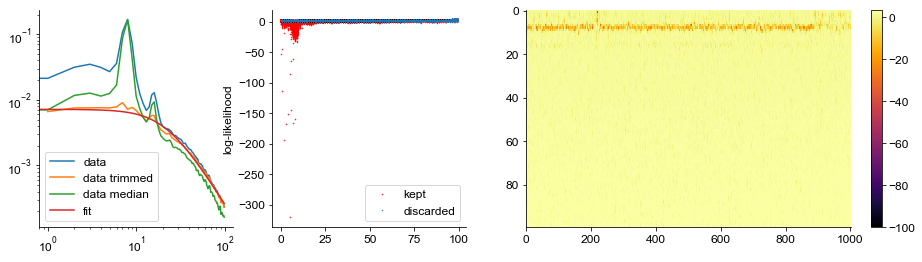

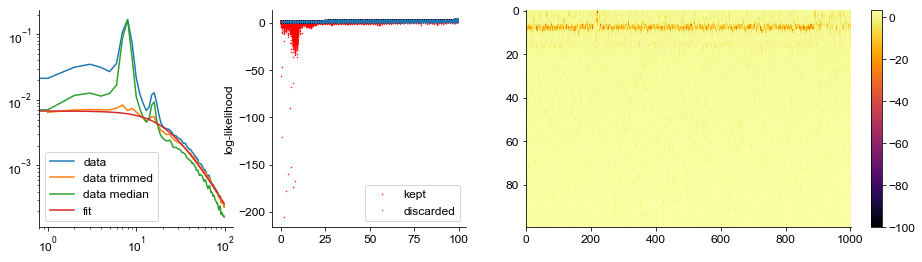

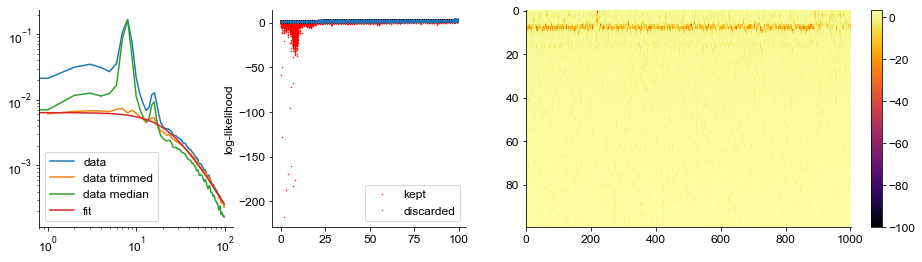

In [39]:
for i in range(20):
    # fit
    res = minimize(total_neglogL, x0, (df_select['freq'].values, df_select['power'].values), bounds=bounds)    
    print('%.2f percent data:'%(len(df_select)/len(df_spg)*100))
    print('offset: %.3f, knee: %.3f, exponent: %.3f'%(res.x[0],res.x[1],res.x[2]))
    
    psd_trim = df_select.groupby('freq').mean()['power']
    
    # compute point-wise log likelihood
    logL = compute_logL_flattened(res.x, df_spg['freq'], df_spg['power']).values
    print('mean trimmed logL: %.3f'%df_select['lh'].mean())
    print('---')
    
    
    # update
    df_spg['lh'] = np.nan
    df_spg.loc[:, 'lh'] = logL
    df_select.loc[:, 'lh'] = logL[df_select.index.values]

    # plot
    plt.figure(figsize=(16,4))
    
    # psds
    plt.subplot(1,4,1)
    plt.loglog(psd.index, psd, label='data')
    plt.loglog(psd_trim.index, psd_trim, label='data trimmed')
    plt.loglog(psd.index, psd_med, label='data median')
    A, k, exp = res.x
    plt.loglog(psd.index, lorentzian(psd.index, *res.x), label='fit')
    plt.legend()
    
    # plot likelihood
    plt.subplot(1,4,2)
    plt.plot(df_spg['freq'],df_spg['lh'], 'r.', ms=1, label='kept')
    plt.plot(df_select['freq'],df_select['lh'], '.', ms=1, label='discarded')
    plt.ylabel('log-likelihood');plt.legend()

    plt.subplot(1,2,2)
    plt.imshow(df_spg['lh'].values.reshape((len(psd),-1)),aspect='auto', vmin=-100)
    plt.colorbar()

    # re-subselect
    df_select = df_select[df_select['lh'] > np.percentile(df_select['lh'],npct)]

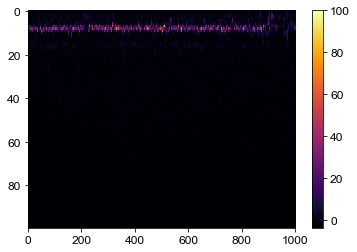

In [37]:
plt.imshow(-df_spg['lh'].values.reshape((len(psd),-1)),aspect='auto', vmax=100)
plt.colorbar()

In [ ]:
# for i in range(20):
#     # fit
#     res = minimize(total_neglogL, x0, (df_select['freq'].values, df_select['power'].values), bounds=bounds)
#     print(res.x)

#     # compute point-wise log likelihood
#     logL = compute_logL_flattened(res.x, df_select['freq'], df_select['power']).values

#     # update
#     df_spg['lh'] = np.nan
#     df_spg.loc[df_select.index.values, 'lh'] = logL
#     df_select.loc[:, 'lh'] = logL

#     # plot
#     plt.figure(figsize=(8,4))
#     plt.subplot(1,2,1)
#     plt.plot(df_spg['freq'],df_spg['lh'], '.', ms=1)

#     plt.subplot(1,2,2)
#     plt.loglog(psd.index, psd, label='data')
#     A, k, exp = res.x
#     plt.loglog(psd.index, lorentzian(psd.index, *res.x), label='full_fit')

#     # re-subselect
#     df_select = df_select[df_select['lh'] >= np.percentile(df_select['lh'],npct)]